# PART 1 (EDA) 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',300)

plt.style.use('ggplot')

import os

path=r'C:\Users\berid\python\fifa\\'

dfs={}
for file in os.listdir(path):
    if file!='male_players.csv':
        title=file.strip('.csv')
        df=pd.read_csv(path+file,nrows=1.5*10**6)
        dfs[title]=df
        print(title)
    else:
        None

In [3]:
import pickle
with open(r"C:\Users\berid\python\data\fifa22_small.pkl",'rb') as f:
    df=pickle.load(f)

In [4]:
df['fifa_update_date']=pd.to_datetime(df['fifa_update_date'])
df=df.sort_values('fifa_update_date')

df=df.drop_duplicates(subset=['short_name','club_name'],keep='last')

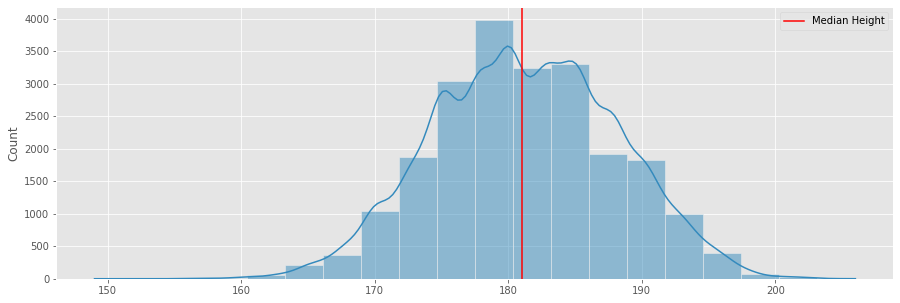

In [5]:
plt.figure(figsize=(15,5))
sns.histplot(data=df,x='height_cm',bins=20,kde=True)
plt.axvline(df['height_cm'].median(),color='r',label='Median Height')
plt.xlabel(None)
plt.legend()
plt.show()

In [6]:
grouped=df.groupby(by='nationality_name').agg({'height_cm':['mean','median','count']}).reset_index()\
.sort_values(('height_cm','mean'),ascending=False)
grouped=grouped[grouped[('height_cm','count')]>=5]

In [7]:
import geopandas

world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [8]:
world=world.replace({'name':{'United States of America':'United States','China':'China PR'}})

In [9]:
grouped=grouped.merge(world,left_on='nationality_name',right_on='name',how='right')

In [10]:
grouped=geopandas.GeoDataFrame(grouped)

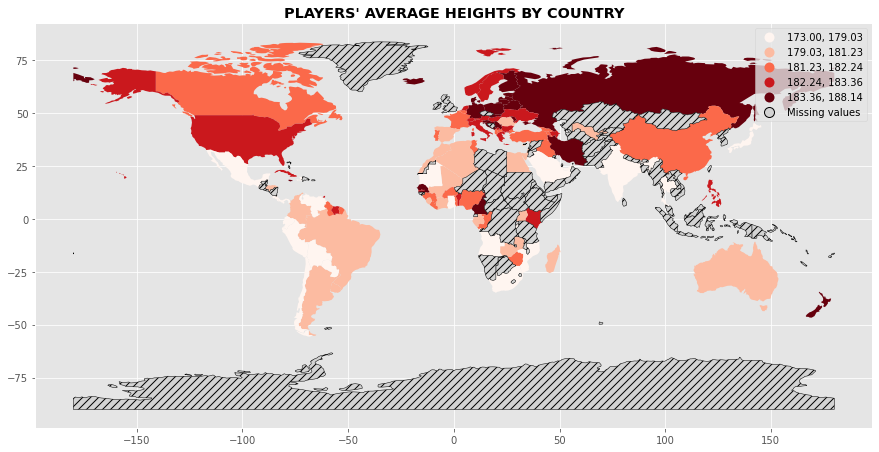

In [11]:
fig,ax=plt.subplots(figsize=(15,15))
grouped.plot(ax=ax,column=('height_cm', 'mean'),legend=True,cmap='Reds',scheme='quantiles',
             missing_kwds={'color':'lightgrey',"edgecolor": "black","hatch": "///","label": "Missing values"})
plt.title("PLAYERS' AVERAGE HEIGHTS BY COUNTRY",fontweight='bold')
plt.show()

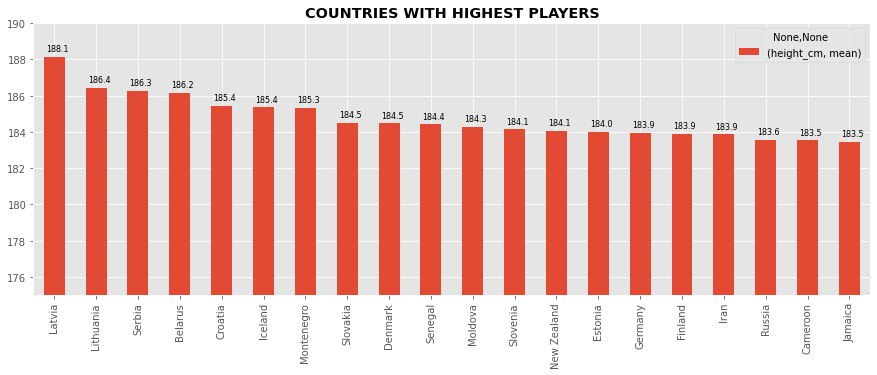

In [12]:
grouped_sorted=grouped.sort_values(('height_cm','mean'),ascending=False).head(20)
grouped_sorted.plot(figsize=(15,5),kind='bar',x=('nationality_name',''),y=('height_cm','mean'))
for i in range(len(grouped_sorted)):
    plt.text(i-0.2,grouped_sorted[('height_cm','mean')].iloc[i]+0.3,grouped_sorted[('height_cm','mean')].iloc[i].round(1),size=8)
plt.ylim(175,190)
plt.title('COUNTRIES WITH HIGHEST PLAYERS',fontweight='bold')
plt.xlabel(None)
plt.show()

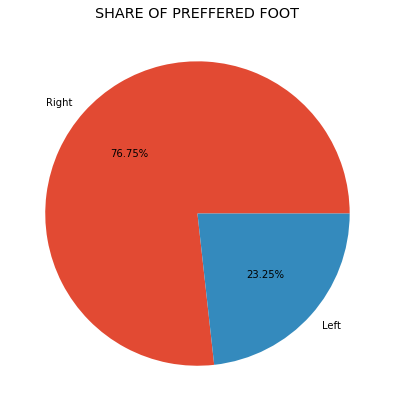

In [13]:
df.value_counts('preferred_foot').plot(figsize=(7,7),kind='pie',ylabel='',title='SHARE OF PREFFERED FOOT',autopct='%.2f%%')
plt.show()

In [14]:
grouped=df.pivot_table(index='nationality_name',columns='preferred_foot',values='short_name',aggfunc='count').reset_index()
grouped['total']=grouped['Left']+grouped['Right']
grouped['left_percentage']=(100*grouped['Left']/grouped['total']).round(2)

grouped=grouped[grouped['total']>=20]

In [15]:
grouped=grouped.merge(world,left_on='nationality_name',right_on='name',how='right')

In [16]:
grouped=geopandas.GeoDataFrame(grouped)

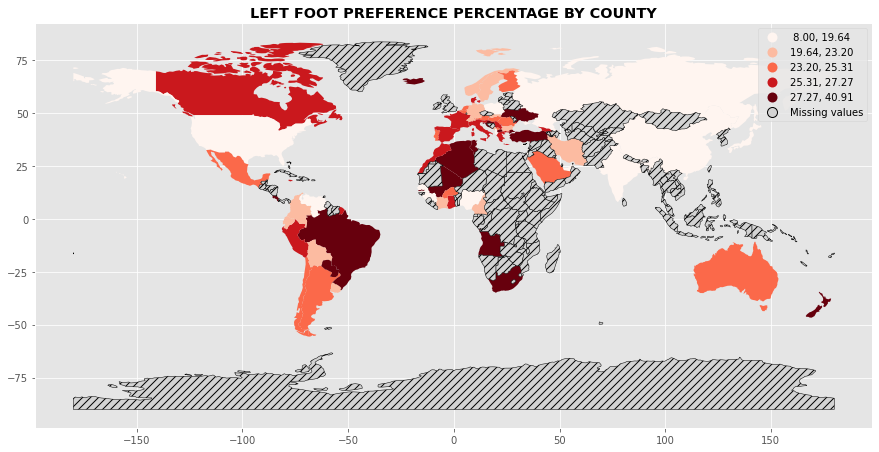

In [17]:
fig,ax=plt.subplots(figsize=(15,15))
grouped.plot(ax=ax,column='left_percentage',legend=True,cmap='Reds',scheme='quantiles',
             missing_kwds={'color':'lightgrey',"edgecolor": "black","hatch": "///","label": "Missing values"})
plt.title("LEFT FOOT PREFERENCE PERCENTAGE BY COUNTY",fontweight='bold')
plt.show()

#  TESTING CENTRAL LIMIT THEORY

In [18]:
n=100

means=[]
for i in range(1,1000):
    mean=df.sample(n=n)['height_cm'].mean()
    means.append(mean)

In [19]:
m=df['height_cm'].mean()
std=df['height_cm'].std()
se=std/(n**0.5)

print(m,std,se)

181.2841395930025 6.8495550832357415 0.6849555083235741


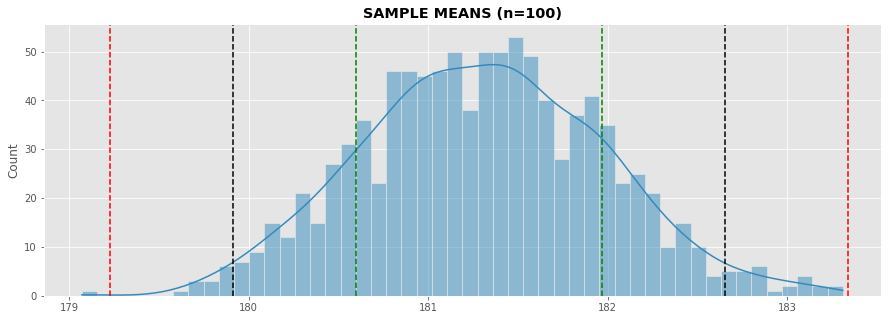

In [20]:
plt.figure(figsize=(15,5))
sns.histplot(means,bins=50,kde=True)
plt.axvline(m-1*se,ls='--',label='1 Standard Error',color='green')
plt.axvline(m+1*se,ls='--',color='green')
plt.axvline(m-2*se,ls='--',label='2 Standard Error',color='black')
plt.axvline(m+2*se,ls='--',color='black')
plt.axvline(m-3*se,ls='--',label='3 Standard Error',color='red')
plt.axvline(m+3*se,ls='--',color='red')
plt.title(f'SAMPLE MEANS (n={n})',fontweight='bold')

plt.show()

In [21]:
one_se=len([i for i in means if m-1*se<i<m+1*se])/len(means)
two_se=len([i for i in means if m-2*se<i<m+2*se])/len(means)
three_se=len([i for i in means if m-3*se<i<m+3*se])/len(means)

print(one_se,two_se,three_se)

0.6836836836836837 0.960960960960961 0.998998998998999


In [22]:
import datetime as dt

In [23]:
df['fifa_update_date']=pd.to_datetime(df['fifa_update_date'])
df['dob']=pd.to_datetime(df['dob'])

In [24]:
df['Age']=(df['fifa_update_date']-df['dob']).dt.days/365

In [25]:
df['BMI']=df['weight_kg']/(df['height_cm']/100)**2

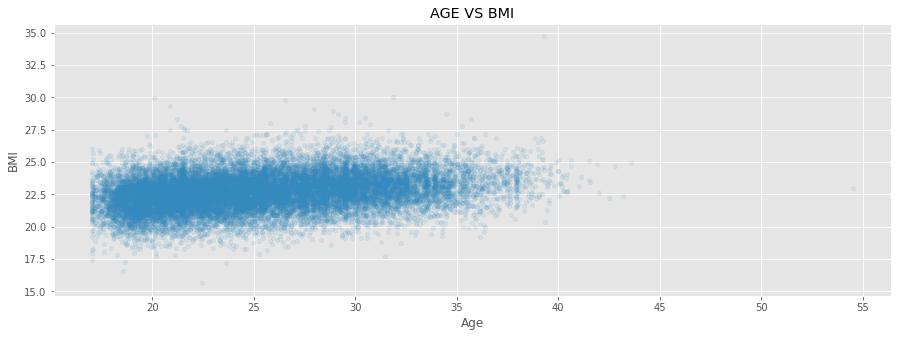

Correlation coefficient: 0.28086495544171475


In [26]:
df.plot(figsize=(15,5),kind='scatter',x='Age',y='BMI',alpha=0.1)
plt.title('AGE VS BMI')
plt.show()

print('Correlation coefficient:',df['Age'].corr(df['BMI']))

# PART 2 (PREDICTING FIFA 22 PLAYER RATINGS USING ACTUAL FOOTBALL STATS FROM https://fbref.com/)

In [27]:
epl=df[df['league_name']=='Premier League']
epl_clubs=['West Ham United','Southampton','Burnley','Everton','Chelsea','Brighton & Hove Albion','Tottenham Hotspur',
          'Aston Villa','Manchester United','Watford','Leeds United','Norwich City','Wolverhampton Wanderers','Arsenal',
          'Manchester City','Liverpool','Leicester City','Newcastle United','Brentford','Crystal Palace']
epl=epl[epl['club_name'].isin(epl_clubs)]

epl=epl.reset_index(drop=True)

# SCRAPING FOOTBALLERS STATS 

In [28]:
from bs4 import BeautifulSoup as bs
import requests

In [29]:
main_url='https://fbref.com/en/comps/9/2020-2021/2020-2021-Premier-League-Stats'

In [30]:
html=requests.get(main_url).content
soup=bs(html,'html.parser')

In [31]:
table=soup.select_one('table[id="results2020-202191_overall"] tbody')

In [32]:
squad_links=[link['href'] for link in table.select('tr td a') if 'squad' in str(link)]
squads=[link.text for link in table.select('tr td a') if 'squad' in str(link)]

In [33]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36'}


dfs={}
for squad, link in zip(squads,squad_links):
    url=f'https://fbref.com{link}'
    url=requests.get(url,headers=headers).content
    standard_stats=pd.read_html(url, match='Standard Stats')[0]
    goalkeeping=pd.read_html(url, match='Goalkeeping')[0]
    advanced_goalkeeping=pd.read_html(url, match='Advanced Goalkeeping')[0]
    shooting=pd.read_html(url, match='Shooting')[0]
    passing=pd.read_html(url, match='Passing')[0]
    goal_and_shot_creation=pd.read_html(url, match='Goal and Shot Creation')[0]
    defensive_actions=pd.read_html(url, match='Defensive Actions')[0]
    possetion=pd.read_html(url, match='Possession')[0]
    playing_time=pd.read_html(url, match='Playing Time')[0]
    miscellaneous_stats=pd.read_html(url, match='Miscellaneous Stats')[0]
    dfs[squad]={
        'standard_stats':standard_stats,
        'goalkeeping':goalkeeping,
        'advanced_goalkeeping':advanced_goalkeeping,
        'shooting':shooting,
        'passing':passing,
        'goal_and_shot_creation':goal_and_shot_creation,
        'defensive_actions':defensive_actions,
        'possetion':possetion,
        'playing_time':playing_time,
        'miscellaneous_stats':miscellaneous_stats
    }
    print(squad)

Manchester City
Manchester Utd
Liverpool
Chelsea
Leicester City
West Ham
Tottenham
Arsenal
Leeds United
Everton
Aston Villa
Newcastle Utd
Wolves
Crystal Palace
Southampton
Brighton
Burnley
Fulham
West Brom
Sheffield Utd


In [35]:
with open('epl_player_stats_2020&2021.pkl','wb') as f:
    pickle.dump(dfs,f)

In [36]:
with open('epl_player_stats_2020&2021.pkl', 'rb') as f:
    players=pickle.load(f)

In [37]:
# removing column levels
# adding prefix to column names. Prefix is the name of the dataframe
# adding Season column


for k1,v1 in players.items():
    for k2,v2 in v1.items():
        if v2 is not None:
            v2.columns=[col[-1] if 'MultiIndex' in str(type(v2.columns)) else col for col in v2.columns]
            v2.columns=[f'{k2}_{col}' if col!='Player' else col for col in v2.columns]
            v2.insert(0,'Team',k1)

In [38]:
#merging dataframes

teams=[]
merged_dfs=[]

for team, dic in players.items():
    teams.append(team)
    merged=pd.DataFrame()
    for k,v in dic.items():
        if len(merged)==0 and v is not None:
            merged=pd.concat([merged,v],axis=1)
        elif len(merged)>0 and v is not None :
            merged=merged.merge(v,on=['Team','Player'],how='left')
            
    
    merged_dfs.append(merged)

In [39]:
# concating dataframes

stats=pd.DataFrame()
for merged in merged_dfs:
    merged = merged.loc[:,~merged.columns.duplicated(keep='first')]
    stats=pd.concat([stats,merged],ignore_index=True)

In [40]:
stats=stats.fillna(0)

# DATA CLEANING 

In [41]:
stats=stats.replace({'Team':
               {'Brighton':'Brighton & Hove Albion','Newcastle Utd':'Newcastle United','Tottenham':'Tottenham Hotspur',
               'West Ham':'West Ham United','Wolves':'Wolverhampton Wanderers','Manchester Utd':'Manchester United'}})

In [42]:
epl['short_name']=epl['short_name'].str.split('.').str[-1].str.split(' ').str[-1].str.strip()

In [43]:
stats['Player']=stats['Player'].str.split(' ').str[-1].str.strip()

In [44]:
target=epl[['short_name','club_name','overall']]

In [45]:
columns_to_remove=[col for col in stats.select_dtypes('object').columns if col not in ['Team','Player']]

In [46]:
stats=stats[stats.columns[stats.columns.isin(columns_to_remove)==False]]

In [47]:
data=stats.merge(target,left_on=['Team','Player'],right_on=['club_name','short_name'])

In [48]:
corr=data.corr()['overall'].sort_values(ascending=False).reset_index()
features=corr[corr['overall']>0.5].drop_duplicates('overall',keep='first')['index'].to_list()
features

['overall',
 'standard_stats_MP',
 'playing_time_90s',
 'standard_stats_Min',
 'miscellaneous_stats_Age',
 'standard_stats_Starts',
 'passing_Cmp%',
 'possetion_Rec',
 'possetion_Touches',
 'possetion_Live',
 'passing_Att',
 'passing_Cmp',
 'passing_TotDist',
 'possetion_Mid 3rd',
 'miscellaneous_stats_Recov',
 'miscellaneous_stats_Won%',
 'goal_and_shot_creation_PassLive',
 'passing_Prog',
 'playing_time_Age',
 'goal_and_shot_creation_SCA',
 'possetion_Att 3rd',
 'passing_PrgDist',
 'passing_1/3',
 'possetion_Succ%',
 'miscellaneous_stats_Fls',
 'goal_and_shot_creation_GCA',
 'shooting_Dist',
 'defensive_actions_Pass']

In [49]:
data=data[data.columns[data.columns.isin(features)]]

In [50]:
data=data[data['overall']>60]

# CREATING ML MODEL 

In [51]:
X=data.drop('overall',axis=1)
Y=data['overall']

from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2)

In [52]:
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [53]:
model=XGBRegressor()
params={ 'learning_rate':[0.02,0.05], 'max_depth':[2,3,5], 'n_estimators':[1000,2000] }

gs=GridSearchCV(model,params,n_jobs=1,verbose=10,cv=3)

gs.fit(xtrain,ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START learning_rate=0.02, max_depth=2, n_estimators=1000.........
[CV 1/3; 1/12] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=0.717 total time=   1.2s
[CV 2/3; 1/12] START learning_rate=0.02, max_depth=2, n_estimators=1000.........
[CV 2/3; 1/12] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=0.698 total time=   1.2s
[CV 3/3; 1/12] START learning_rate=0.02, max_depth=2, n_estimators=1000.........
[CV 3/3; 1/12] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=0.634 total time=   1.1s
[CV 1/3; 2/12] START learning_rate=0.02, max_depth=2, n_estimators=2000.........
[CV 1/3; 2/12] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=0.705 total time=   2.4s
[CV 2/3; 2/12] START learning_rate=0.02, max_depth=2, n_estimators=2000.........
[CV 2/3; 2/12] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=0.696 total time=   2.4s
[CV 3/3; 2/12] STAR

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...ehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
   

In [54]:
gs.best_params_
#{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 1000}

{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 1000}

In [55]:
model=XGBRegressor(learning_rate=0.02,max_depth=3,n_estimators=1000)

In [56]:
model.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [57]:
train_prediction=model.predict(xtrain)
test_prediction=model.predict(xtest)

In [58]:
r2_train=metrics.r2_score(train_prediction,ytrain)
r2_test=metrics.r2_score(test_prediction,ytest)

mae_train=metrics.mean_absolute_error(train_prediction,ytrain)
mae_test=metrics.mean_absolute_error(test_prediction,ytest)

rmse_train=metrics.mean_squared_error(train_prediction,ytrain,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,ytest,squared=False)

print('R2, MAE ,RMSE for train and test data are:')
print(r2_train,r2_test)
print(mae_train,mae_test)
print(rmse_train,rmse_test)

R2, MAE ,RMSE for train and test data are:
0.9712170646854326 0.6901628921456326
0.7468542291597745 2.4028217266132303
1.0333815224675926 3.074403876784056


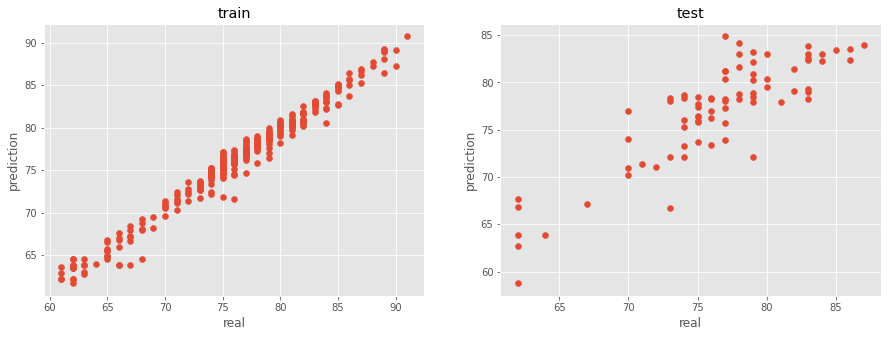

In [59]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(ytrain,train_prediction)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')

ax2.scatter(ytest,test_prediction)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')
plt.show()